In [57]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

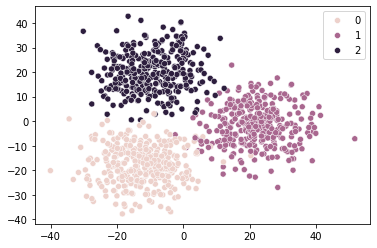

In [58]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [59]:
# model = RandomForestClassifier()
model = KMeans(n_clusters=3)
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

/home/jacob/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,-10.975598,-2.689973,-3.773780,4.833034,14.655913,-12.497271,20.964576,-5.639884,-3.614017,4.260946,...,-2.673597,-17.990279,1.022908,2.108774,8.546619,18.369497,10.612239,11.725223,-9.943659,0.0
1,-8.212486,8.178123,-3.593744,-8.108861,4.950249,-8.363374,15.973536,-19.443236,-11.964883,-18.636477,...,2.445271,-5.309250,-9.163252,6.775745,-4.536835,1.998467,8.751263,-7.420864,0.107550,0.0
2,6.928764,7.040612,5.740637,4.517768,4.543899,-5.890066,7.114563,0.087305,-15.260616,-7.953275,...,-19.674340,3.104577,-5.265248,1.008184,19.762190,11.113920,-4.412452,3.638701,3.729838,0.0
3,1.850185,-7.888109,-8.239373,-15.781007,4.758952,7.965239,13.300551,2.149231,16.798471,-12.410850,...,-4.344281,4.324272,-12.744883,5.765068,7.150673,12.694435,-10.126050,2.472047,-22.996140,0.0
4,-7.643534,11.291771,7.047296,2.473077,-7.236482,-6.200150,-4.954889,22.085668,18.278712,-7.696110,...,9.415386,3.922890,16.998075,10.198718,5.123529,-4.029592,1.881594,10.624919,-0.997825,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.090348,18.928005,20.052973,-0.114374,0.501763,-3.416268,-15.686213,-1.606249,11.177334,-8.976443,...,8.546925,1.521916,-12.968402,11.482556,-7.803453,7.388260,16.911723,-6.606315,-5.391906,2.0
996,1.456553,-8.094539,-0.180017,-9.262959,-5.343254,-12.127804,21.183859,-0.269166,8.666900,3.416827,...,16.556433,8.181280,20.722585,-11.902249,6.883715,-10.748055,-1.003982,16.055847,10.445352,1.0
997,8.744122,-0.541112,22.384989,-6.035118,5.326548,-1.944958,1.125537,9.888444,-0.985227,-12.811279,...,15.207744,30.375648,4.834641,-8.215548,18.646476,2.838962,-5.211517,5.829355,13.931915,1.0
998,6.511785,2.266709,-0.880025,-13.357600,-5.080314,-15.218103,0.253269,-3.858016,-17.956150,-15.532494,...,-3.846322,8.417774,-7.280501,-17.181385,9.371388,15.242041,4.517235,3.570957,-10.203358,0.0


<Axes: >

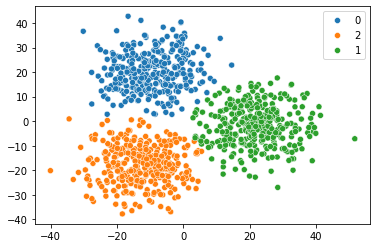

In [60]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [61]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]

    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))

    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        # point_pred = int(model.predict([X[initial_instance_index]])[0])
        target_cluster_center = model.cluster_centers_[target._target_value]
        
        target_cluster_indices = np.where(y == target._target_value)

        min_target_cluster_distance = np.min([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        # max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X])

        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, min_target_cluster_distance, max_target_cluster_distance, target_cluster_center)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [62]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
# t = Target(target_type="classification", target_feature="label", target_value=2)
t = Target(target_type="clustering_kmeans", target_feature="label", target_value=2)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  0 <class 'int'>
--- Executing... Initial Instance: 0 Target: 2 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
[0.99898247 0.9985218  0.9985218  0.99934926 0.99909747 0.99343332
 0.99909193 0.9986335  0.99006849 0.99773205 0.99929869 0.99798953
 0.99803665 0.99711099 0.98861415 0.99620289 0.99564398 0.98909893
 0.99522683 0.99764938 0.99902499 0.99929869 0.99906651 0.99469598
 0.99906372 0.99620289 0.99450249 0.99681129 0.9994368  0.99125356
 0.99733038 0.99870494 0.99800796 0.99835045 0.9930554  0.9985218
 0.99619585 0.99858418 0.99858418 0.99928475 0.99786658 0.99055327
 0.99667957 0.99377329 0.99861543 0.99691533 0.9976475  0.998077
 0.99752553 0.9994669  0.99709299 0.99911593 0.99832445 0.99055327
 0.99605984 0.98861415 0.999043   0.99854199 0.99798953 0.99909747
 0.99744967 0.99777643 0.99940037 0.99907979 0.99764938 0.99929869
 0.99656068 0.99940037 0.99929869 0.9985218  0.99849039 0.99463096
 0.99764938 0.99874156 0

[0 0 0 ... 0 0 0]


<Axes: >

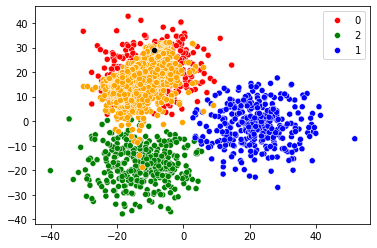

In [63]:
embed_cf = pca.transform(cf)
print(model.predict(cf))
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')